In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from pathlib import Path
import numpy as np
import multiprocessing
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/hzh/anaconda3/envs/segformer/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check if cuda is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Model

In [3]:
v = 0     # model version
in_c = 2  # number of input channels
num_c = 1 # number of classes to predict

In [4]:
# The optical flow input will look like this
# of = torch.randn(1,2,640,480)

In [5]:
model = EfficientNet.from_pretrained(f'efficientnet-b{v}', in_channels=in_c, num_classes=num_c)
model.to(device);

Loaded pretrained weights for efficientnet-b0


#### The output of the model will look like this

In [6]:
# of = of.to(device)
# model(of).item()

## Data

In [23]:
# directory with the optical flow images
of_dir = '../../run.epoch-0-flow-field'
# labels as txt file
labels_f = './train.txt'

In [24]:
class OFDataset(Dataset):
    def __init__(self, of_dir, label_f):
        self.len = len(list(Path(of_dir).glob('*.flo')))
        self.of_dir = of_dir
        self.label_file = open(label_f).readlines()
    def __len__(self): return self.len
    def __getitem__(self, idx):
        f = open(Path(self.of_dir)/f'{idx}.flo', 'rb')
        x = np.fromfile(f, np.int32, count=1) # not sure what this gives
        w = np.fromfile(f, np.int32, count=1) # width
        h = np.fromfile(f, np.int32, count=1) # height
        data = np.fromfile(f, np.float32) # vector
        of_array = np.reshape(data, (2, h[0], w[0]))
        
        # of_array = np.load(Path(self.of_dir)/f'{idx}.flo')
        of_tensor = torch.squeeze(torch.Tensor(of_array))
        label = float(self.label_file[idx].split()[0])
        return [of_tensor, label]

In [25]:
ds = OFDataset(of_dir, labels_f)

In [26]:
# 80% of data for training
# 20% of data for validation
train_split = .8

In [27]:
ds_size = len(ds)
indices = list(range(ds_size))
split = int(np.floor(train_split * ds_size))

In [57]:
train_idx, val_idx = indices[:split], indices[3000:5000]

In [58]:
sample = ds[3]
assert type(sample[0]) == torch.Tensor
assert type(sample[1]) == float

In [59]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [60]:
cpu_cores = multiprocessing.cpu_count()
cpu_cores

8

In [61]:
train_dl = DataLoader(ds, batch_size=8, sampler=train_sampler, num_workers=0)
val_dl = DataLoader(ds, batch_size=8, sampler=val_sampler, num_workers=0)

In [62]:
def plot(train_loss,val_loss,title, filename):
    N = len(train_loss)
    plt.plot(range(N),train_loss,label = 'train_loss')
    plt.plot(range(N),val_loss, label = 'val_loss')
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.legend()
    plt.savefig(f"./loss/{filename}.png")
    plt.show()

In [63]:
model = EfficientNet.from_name(f'efficientnet-b{v}', in_channels=in_c, num_classes=num_c)
model.to(device);

In [37]:
history_train_loss = np.load('trainLossFlowNet2.npy')

In [64]:
# history_train_loss = []
history_val_loss = []
epochs = 25
for epoch in range(epochs):
    # validation
    model.load_state_dict(torch.load(f'./flow{epoch}.pth'))
    criterion = nn.MSELoss()
    model.eval()
    val_losses = []
    with torch.no_grad():
        for j, val_sample in enumerate(tqdm(val_dl)):
            of_tensor = val_sample[0].cuda()
            label = val_sample[1].float().cuda()
            pred = torch.squeeze(model(of_tensor))
            loss = criterion(pred, label)
            val_losses.append(loss)
        mean_val_loss = sum(val_losses)/len(val_losses)
        # torch.save(model.state_dict(), f'./flow{epoch}.pth')
        # if(mean_val_loss < best_loss):
            # torch.save(model.state_dict(), f'./flow{epoch}_best.pth')
            # best_loss = mean_val_loss
        history_val_loss.append(mean_val_loss.cpu().detach().numpy())
        print(f'{epoch}: {mean_val_loss}')

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 35.50it/s]


0: 238.50726318359375


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 36.28it/s]


1: 162.3183135986328


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 37.03it/s]


2: 120.35316467285156


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 36.25it/s]


3: 61.729347229003906


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 36.43it/s]


4: 69.91668701171875


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 37.00it/s]


5: 173.96365356445312


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 37.47it/s]


6: 87.90520477294922


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 36.18it/s]


7: 170.1593017578125


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 36.90it/s]


8: 140.0213623046875


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 37.15it/s]


9: 183.31712341308594


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 36.95it/s]


10: 130.37826538085938


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 32.33it/s]


11: 89.59683990478516


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 38.21it/s]


12: 65.361083984375


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 38.09it/s]


13: 179.0017547607422


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 35.73it/s]


14: 119.88298034667969


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 37.93it/s]


15: 36.08540344238281


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 35.18it/s]


16: 99.547119140625


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 32.97it/s]


17: 113.30339813232422


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 37.08it/s]


18: 130.9442901611328


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 36.83it/s]


19: 133.77456665039062


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 35.53it/s]


20: 118.6864242553711


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 34.21it/s]


21: 216.1866455078125


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 34.60it/s]


22: 170.86741638183594


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 35.69it/s]


23: 154.90126037597656


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 37.09it/s]

24: 176.513916015625


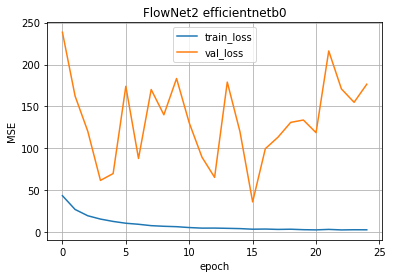

In [65]:
plot(history_train_loss,history_val_loss,"FlowNet2 efficientnetb0", "use tricky")

In [66]:
min(history_val_loss)

array(36.085403, dtype=float32)